# Masking Algorithm

This notebook is a sandbox to design the masking algorithm for training the self-supervised Transformer for this project. The masking algorithm should

- perform missing completely at random
- perform missing in blocks
- perform intermittent missing data

Each of these should occur in a batch with probabiliy $\epsilon$. 

Each of these should also only affect up to the index where data is present. The sequences are padded with zeros to make them a fixed length. Missing data should not be present when 0 padded.

In [152]:
import DataUtils
import torch
import numpy as np
import matplotlib.pyplot as plt

### Loading Data

In [159]:
trainloader, testloader = DataUtils.get_dataloaders(32)

In [338]:
example = next(enumerate(trainloader))
ex_X = example[1][0]
ex_y = example[1][1]

In [157]:
print(ex_X.shape, ex_y.shape)

torch.Size([32, 543, 27]) torch.Size([32, 543])


### Defining Masking Functions

First, mask completely at random. Fill with -1 to signify missing data.

In [217]:
def mask_random(batched_data):
    masked = batched_data.clone()
    percent_missing = np.random.randint(30, 60) / 100
    random_mask = (torch.FloatTensor(masked.shape).uniform_() > percent_missing)

    masked[random_mask] *= -1
    masked[masked < 0] = -1
    return masked

In [218]:
masked = mask_random(ex_X)
(torch.sum(masked.flatten(0) != -1)) / masked.flatten(0).shape[0]

tensor(0.7796)

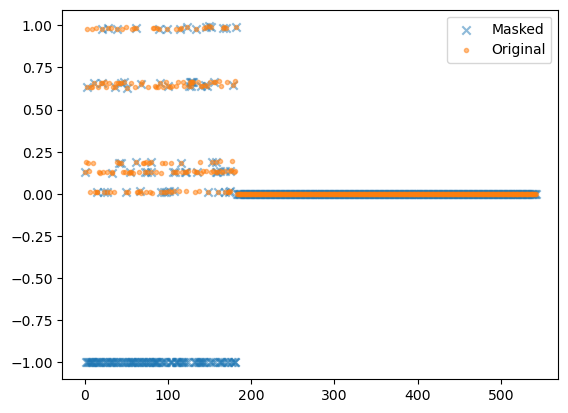

In [219]:
plt.scatter(range(543), masked[0][:,6], label='Masked', alpha=0.5, marker="x")
plt.scatter(range(543), ex_X[0][:,6], label='Original', alpha=0.5, marker=".")
plt.legend()

In [315]:
def mask_intermittently(batched_data):
    masked = batched_data.clone()
    n_cols = np.random.randint(0, batched_data.shape[2])
    cols = np.random.choice(list(range(n_cols)), n_cols, replace=False)
    checkerboard_mask = np.ones(masked.shape[1])
    checkerboard_mask[0::2] = -1

    masked[:, :, cols] = (masked[:, :, cols] * np.expand_dims(np.expand_dims(checkerboard_mask, 0), 2))
    masked[masked < 0] = -1
    return masked

In [346]:
masked = mask_intermittently(ex_X)

(1, 543, 1)
[5 6 0 3 1 2 7 8 4]


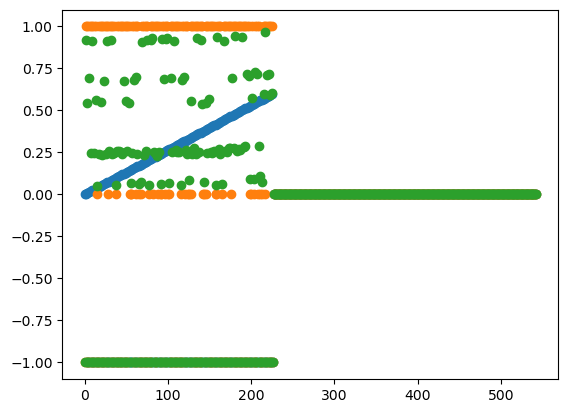

In [347]:
plt.scatter(range(543), masked[0][:,1])
plt.scatter(range(543), masked[0][:,4])
plt.scatter(range(543), masked[0][:,8])

In [ ]:
def mask_blocks(batched_data):
    pass

In [343]:
import torch

# Written by ChatGPT
def mask_blocks(batched_data):
    x = batched_data.clone()
    batch_size, seq_len, num_features = x.shape

    # Create a mask tensor to indicate which elements of the tensor should be masked
    mask = torch.zeros((batch_size, seq_len), dtype=torch.bool)

    # Iterate over each element in the batch
    for i in range(batch_size):
        # Get the sequence for the current example
        seq = x[i]

        # Determine the length of the non-padded sequence
        non_padded_len = torch.nonzero(seq[:, 0]).shape[0]

        # Randomly select the number of blocks to mask (1-5)
        num_blocks = torch.randint(1, 6, size=(1,)).item()

        # Iterate over each block to mask
        for j in range(num_blocks):
            # Randomly select the length of the block (5-20)
            block_len = torch.randint(5, 21, size=(1,)).item()

            # Randomly select the start index of the block
            start_index = torch.randint(0, non_padded_len - block_len + 1, size=(1,)).item()

            # Mask the selected block
            mask[i, start_index:start_index + block_len] = True

    # Apply the mask to the tensor and replace masked values with -1
    x[mask.unsqueeze(-1).expand_as(x)] = -1

    return x


In [348]:
masked = mask_blocks(ex_X)

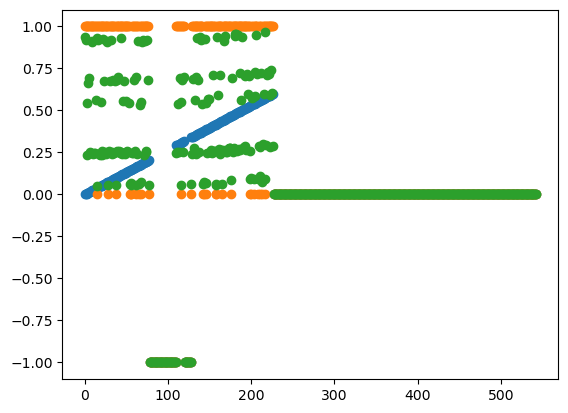

In [349]:
plt.scatter(range(543), masked[0][:,1])
plt.scatter(range(543), masked[0][:,4])
plt.scatter(range(543), masked[0][:,8])